# TODO: Explore data, preprocess data, tune hyperparameters, repeat...

There's a weird like x^3 curve in our residuals so we gotta do more data exploration :(

### Prepping Data

In [115]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
# %load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import itertools
from data_processing import prepData, transformData
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold, cross_val_score # for training a model
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from mlxtend.evaluate import bias_variance_decomp

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough

df = prepData(df)
display(df)

,Rented Bike Count,Temperature(C),Humidity(%),Wind Speed(m/s),Solar Radiation(MJ/m2),Rainfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp
Date,,,,,,,,,,,,
2017-12-01,9539,-2.454167,45.875000,1.537500,1.16,0.0,0,0,0,1,0,-0.0
2017-12-02,8523,1.325000,61.958333,1.712500,1.12,0.0,0,0,0,1,1,0.0
2017-12-03,7222,4.875000,81.541667,1.612500,0.69,4.0,0,0,0,1,1,0.0
2017-12-04,8729,-0.304167,52.500000,3.450000,1.17,0.1,0,0,0,1,0,-0.0
2017-12-05,8307,-4.458333,36.416667,1.108333,0.64,0.0,0,0,0,1,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,70.500000,1.029167,1.74,0.0,0,0,1,0,0,0.0
2018-11-27,16282,7.066667,68.000000,1.350000,0.87,0.0,0,0,1,0,0,0.0
2018-11-28,16524,5.304167,25.791667,1.695833,1.86,0.0,0,0,1,0,0,0.0


In [116]:
y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)

## Things to look for going into testing models
From the slides, there's a few models we can knock off our list
- We're targeting a numerical value so that means we'll need a regression model (minimizing mse and rmse, maximizing r2)
- We'll need for it to handle multicollinearity because weather effects are usually correlated with each other
- We've scaled down rainfall and snowfall but we still have outliers so it should handle those well

I looked up a good chunk of the regression models on sklearn and imported them

In [76]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import ARDRegression, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, LinearRegression
from sklearn.linear_model import QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, BayesianRidge
from sklearn.linear_model import TheilSenRegressor, TweedieRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,  HistGradientBoostingRegressor, RandomForestRegressor

# Model Testing
I've separated the model testing into 2 parts
- Part 1: Testing default values for almost every regression model on sklearn
- Part 2: From the best performing models in part 1, try out some hyperparameter combinations
## Part 1

In [45]:
all_model = { # random_state=1 for reproductability
    'DecisionTree' : DecisionTreeRegressor(random_state=1),
    'ExtraTree' : ExtraTreeRegressor(random_state=1),
    'KNeighbors' : KNeighborsRegressor(),
    'KernelRidge' : KernelRidge(),
    'LinearSVR' : LinearSVR(random_state=1),
    'SVR' : SVR(),
    'NuSVR' : NuSVR(),
    'ARDRegression' : ARDRegression(),
    'ElasticNet' : ElasticNet(random_state=1),
    'ElasticNetCV' : ElasticNetCV(random_state=1),
    'HuberRegressor' : HuberRegressor(),
    'Lars' : Lars(random_state=1),
    'LarsCV' : LarsCV(),
    'Lasso' : Lasso(random_state=1),
    'LassoCV' : LassoCV(random_state=1),
    'LassoLarsCV' : LassoLarsCV(),
    'LassoLarsIC' : LassoLarsIC(),
    'LinearRegression' : LinearRegression(),
    'QuantileRegressor' : QuantileRegressor(),
    'RANSACRegressor' : RANSACRegressor(random_state=1),
    'Ridge' : Ridge(random_state=1),
    'RidgeCV' : RidgeCV(),
    'SGDRegressor' : SGDRegressor(random_state=1),
    'BayesianRidge' : BayesianRidge(),
    'TheilSenRegressor' : TheilSenRegressor(random_state=1),
    'TweedieRegressor' : TweedieRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1),
    'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=1),
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor(random_state=1),
    'RandomForestRegressor' : RandomForestRegressor(random_state=1),
    'XGBRegressor' : XGBRegressor()
    }

screening = [] # our output

for name, model in all_model.items():
    print(name) # for debugging

    reg = model.fit(X_train, y_train)

    train_pred = reg.predict(X_train)
    test_pred = reg.predict(X_test)
    
    cv_r2_score = round(np.mean(cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2')), 2)
    r2_train = round(r2_score(y_train, train_pred), 2)
    r2_test = round(r2_score(y_test, test_pred), 2)
    mse_train = round(mean_squared_error(y_train, train_pred), 2)
    mse_test = round(mean_squared_error(y_test, test_pred), 2)
    rmse = np.sqrt(mse_test)
    screening.append([name, r2_test, r2_train, mse_test, mse_train, rmse, cv_r2_score])

# converting output to a dataframe and adding column names
screening_df = pd.DataFrame(screening, columns=('model', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'rmse', 'cv_r2_score'))

# makes it easier to find overfitting, should be positive
screening_df['r2_diff'] = screening_df['r2_test'] - screening_df['r2_train']

# makes it easier to find overfitting, should be negative
screening_df['mse_diff'] = screening_df['mse_test'] - screening_df['mse_train']

clear_output(True) # clean up output
display(screening_df.sort_values(['r2_test', 'r2_diff'], ascending=False))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
28,HistGradientBoostingRegressor,0.91,0.98,8.677832e+06,1.910420e+06,2945.816016,0.90,-0.07,6767411.57
27,GradientBoostingRegressor,0.91,0.99,8.612745e+06,1.350710e+06,2934.747822,0.91,-0.08,7262035.09
26,ExtraTreesRegressor,0.90,1.00,9.784458e+06,0.000000e+00,3128.011872,0.92,-0.10,9784458.27
29,RandomForestRegressor,0.88,0.99,1.127383e+07,1.286410e+06,3357.651904,0.90,-0.11,9987415.89
30,XGBRegressor,0.88,1.00,1.144184e+07,4.607000e+01,3382.578159,0.87,-0.12,11441788.93
22,SGDRegressor,0.87,0.88,1.287609e+07,1.168010e+07,3588.327390,0.87,-0.01,1195990.29
3,KernelRidge,0.87,0.89,1.273371e+07,1.143239e+07,3568.432090,0.87,-0.02,1301317.58
20,Ridge,0.87,0.89,1.273040e+07,1.132611e+07,3567.968821,0.87,-0.02,1404290.10
10,HuberRegressor,0.87,0.90,1.293980e+07,9.760080e+06,3597.194022,0.89,-0.03,3179724.38
7,ARDRegression,0.86,0.90,1.324375e+07,9.514081e+06,3639.196422,0.89,-0.04,3729669.24


In [46]:
# finding models that have similar r2 for train and test and have good values
display(screening_df.loc[(screening_df['r2_diff']>=-0.15) & (screening_df['r2_test']>=0.70)].sort_values(['r2_diff', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
8,ElasticNet,0.77,0.76,22025453.84,24328164.19,4693.128364,0.75,0.01,-2302710.35
22,SGDRegressor,0.87,0.88,12876093.46,11680103.17,3588.327390,0.87,-0.01,1195990.29
20,Ridge,0.87,0.89,12730401.51,11326111.41,3567.968821,0.87,-0.02,1404290.10
3,KernelRidge,0.87,0.89,12733707.58,11432390.00,3568.432090,0.87,-0.02,1301317.58
10,HuberRegressor,0.87,0.90,12939804.83,9760080.45,3597.194022,0.89,-0.03,3179724.38
21,RidgeCV,0.86,0.90,12987535.02,9543918.29,3603.822279,0.89,-0.04,3443616.73
14,LassoCV,0.86,0.90,13058806.01,9519725.72,3613.697000,0.89,-0.04,3539080.29
23,BayesianRidge,0.86,0.90,13110646.67,9507534.16,3620.862697,0.89,-0.04,3603112.51
7,ARDRegression,0.86,0.90,13243750.60,9514081.36,3639.196422,0.89,-0.04,3729669.24
13,Lasso,0.86,0.90,13284267.32,9487994.90,3644.758884,0.89,-0.04,3796272.42


In [126]:
display(screening_df.iloc[[10, 26]])

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
10,HuberRegressor,0.87,0.9,12939804.83,9760080.45,3597.194022,0.89,-0.03,3179724.38
26,ExtraTreesRegressor,0.90,1.0,9784458.27,0.00,3128.011872,0.92,-0.10,9784458.27


# Models we'll be working with
Throughout all data manipulation, Huber consistently does ok so it's gotta be fate or something
- HuberRegressor (L2, regularizer that's good w outliers, reduces overfitting)
- ExtraTreesRegressor (To say that we at least tried a tree-based model)

## Part 2: Tuning hyperparameters
- n_jobs=* declares how many processors your computer will use; -1 uses all. Change at your own risk
<p>If a hyperparameter isn't listed for a model then it doesn't have a significant effect on its performance (based off my testing (byron))

In [ ]:
param_dict = {
    'HuberRegressor' : {
        'epsilon' : [1.0, 1.35, 2.0, 3.0, 4.0, 5.0],
        'alpha': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10],
        'max_iter': [100, 250, 500, 1000]},
    'ExtraTreesRegressor' : {
        'max_depth' : [6, 15, 30],
        'min_samples_split' : [2, 9, 12, 50, 100],
        'min_samples_leaf' : [1, 10, 13, 50, 100],
        'n_estimators': [5, 50, 100, 500]},
}

model_dict = {
    'HuberRegressor' : HuberRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1, n_jobs=-1),
}

### Bayesian Optimization

In [124]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
import copy
from sklearn.exceptions import ConvergenceWarning

# common warning because bayesian search tries not to redo configurations when picking random ones
warnings.filterwarnings("ignore", message="The objective has been evaluated at point")

# bayes might try low # of iterations, better to ignore this warning than see it 10 billion times
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# only run the specified models and pick the top n by their r2 
def baye_searcher(models_to_run, top_n=10):
    summary = [] # our output

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue

        start_time = time.time() # for tracking time
        print(f"Now working on {name}")

        # BayesSearch uses search spaces instead of param grids so we have to convert
        search_space = copy.deepcopy(param_dict[name])
        for param, values, in search_space.items():
            if isinstance(values[0], str):
                search_space[param] = tuple(values)
            if isinstance(values[0], bool):
                search_space[param] = Categorical(categories=(False, True))
            if isinstance(values[0], int):
                search_space[param] = Integer(min(values), max(values))
            if isinstance(values[0], float):
                search_space[param] = Real(min(values), max(values))

        # finds the best model configuration to maximize R2
        iterations = 20 # defaults to 20 iterations unless we specify we want more
        if top_n > iterations: iterations = top_n
        b_search = BayesSearchCV(estimator=model, search_spaces=search_space, cv=cv, random_state=1, scoring='r2', return_train_score=True, n_jobs=-1, n_iter=iterations, n_points=4)
        b_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(b_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        results = results.sort_values('r2_diff', ascending=False).head(top_n)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())

            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)
            
            # gathering metrics
            r2_train = round(r2_score(y_train, train_pred), 3)
            r2_test = round(r2_score(y_test, test_pred), 3)
            mse_train = round(mean_squared_error(y_train, train_pred), 3)
            mse_test = round(mean_squared_error(y_test, test_pred), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # converting output to a dataframe and adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # Drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

Bayesian Search is a fast way to find good parameters
<br>This is useful for determining which parameters dont affect our accuracy

### Grid Search
More time consuming because it tries every configuration in our param dictionary and finds the best one

In [123]:
from sklearn.model_selection import GridSearchCV

# only run the specified models and pick the top n by their r2 
def grid_searcher(models_to_run, top_n=-1):
    summary = [] # our output

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue
        if top_n < 1: len(list(itertools.product(param_dict[name])))
        start_time = time.time() # for tracking time
        print(f"Now working on {name}")
        # finds the best model configuration to maximize R2
        grid_search = GridSearchCV(estimator=model, param_grid=param_dict[name], scoring='r2', cv=cv, n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(grid_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        if top_n > len(results): top_n = len(results)
        results = results.sort_values('r2_diff', ascending=False).head(top_n)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())
        
            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)

            # gathering metrics
            r2_train = round(r2_score(y_train, train_pred), 3)
            r2_test = round(r2_score(y_test, test_pred), 3)
            mse_train = round(mean_squared_error(y_train, train_pred), 3)
            mse_test = round(mean_squared_error(y_test, test_pred), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train, y_train, X_test, y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # Drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

I put it in a separate function because it takes forever and I (byron) don't want to leave my pc on for hours waiting
<br>This way we can do a few models at a time and keep the output
<p>Out of the 3 tuning methods, I only implemented Bayesian and Grid Searching
<br>Bayesian is a more generalized method that sometimes finds the exact parameter values that work best
<br>Grid on the other hand, only uses the parameter values we give it. That makes it better for fine tuning

In [67]:
tune1_params = ['HuberRegressor']
tune1 = baye_searcher(tune1_params, 100)

Now working on HuberRegressor
Skipping OrderedDict({'alpha': 6.471137772264397, 'epsilon': 1.0, 'max_iter': 100}) due to HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL: 
HuberRegressor took 427.40 seconds


In [89]:
tune12_params = ['HuberRegressor']
tune12 = grid_searcher(tune12_params)

Now working on HuberRegressor
HuberRegressor took 691.51 seconds


In [122]:
tune1_results = pd.concat([tune1, tune12], axis=0)
display(tune1_results.loc[(tune1_results['r2_diff']>=0) & (tune1_results['r2_test']>=0.8) & (tune1_results['rmse']<4000)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2,param3,val3
156,HuberRegressor,0.855,0.855,1.389989e+07,1.438465e+07,1.474197e+07,1.398089e+07,7.610766e+05,3728.255413,0.000,-484760.582,alpha,0.001000,epsilon,2.000000,max_iter,100
157,HuberRegressor,0.855,0.855,1.389989e+07,1.438465e+07,1.474197e+07,1.398089e+07,7.610766e+05,3728.255413,0.000,-484760.582,alpha,0.001000,epsilon,2.000000,max_iter,250
158,HuberRegressor,0.855,0.855,1.389989e+07,1.438465e+07,1.474197e+07,1.398089e+07,7.610766e+05,3728.255413,0.000,-484760.582,alpha,0.001000,epsilon,2.000000,max_iter,500
159,HuberRegressor,0.855,0.855,1.389989e+07,1.438465e+07,1.474197e+07,1.398089e+07,7.610766e+05,3728.255413,0.000,-484760.582,alpha,0.001000,epsilon,2.000000,max_iter,1000
160,HuberRegressor,0.855,0.851,1.390102e+07,1.484798e+07,1.506906e+07,1.398413e+07,1.084927e+06,3728.406679,0.004,-946968.210,alpha,0.001000,epsilon,1.350000,max_iter,100
161,HuberRegressor,0.855,0.851,1.390102e+07,1.484798e+07,1.506906e+07,1.398413e+07,1.084927e+06,3728.406679,0.004,-946968.210,alpha,0.001000,epsilon,1.350000,max_iter,250
162,HuberRegressor,0.855,0.851,1.390102e+07,1.484798e+07,1.506906e+07,1.398413e+07,1.084927e+06,3728.406679,0.004,-946968.210,alpha,0.001000,epsilon,1.350000,max_iter,500
163,HuberRegressor,0.855,0.851,1.390102e+07,1.484798e+07,1.506906e+07,1.398413e+07,1.084927e+06,3728.406679,0.004,-946968.210,alpha,0.001000,epsilon,1.350000,max_iter,1000
97,HuberRegressor,0.851,0.844,1.426795e+07,1.546776e+07,1.566672e+07,1.428300e+07,1.383714e+06,3777.294041,0.007,-1199808.258,alpha,0.001089,epsilon,1.153329,max_iter,919
91,HuberRegressor,0.851,0.849,1.430241e+07,1.505507e+07,1.507333e+07,1.436888e+07,7.044526e+05,3781.852138,0.002,-752667.082,alpha,0.001352,epsilon,2.511982,max_iter,314


In [30]:
tune3_params = ['ExtraTreesRegressor']
tune3 = baye_searcher(tune3_params, 50)

Now working on ExtraTreesRegressor
ExtraTreesRegressor took 2675.88 seconds


In [31]:
tune32_params = ['ExtraTreesRegressor']
tune32 = grid_searcher(tune32_params, 50)

Now working on ExtraTreesRegressor
ExtraTreesRegressor took 1786.36 seconds


In [33]:
tune3_results = pd.concat([tune3, tune32], axis=0)
display(tune3_results.loc[(tune3_results['r2_diff']>=-0.01) & (tune3_results['r2_test']>=0.8)].sort_values(['r2_test', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2,param3,val3,param4,val4


## Tuned Model

In [47]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = np.sqrt(mse_test)

    clear_output(True)
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Alternatively, it's off by an average of {round(rmse_test)} bikes")

    # Visualizations
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlim(0, 36000)
    ax[0].set_ylim(-5000, 36000)
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train, y_train, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlim(0, 36000)
    ax[1].set_ylim(-5000, 36000)
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()

Test Accuracy: 85.52%
Train Accuracy: 85.07%
Accuracy Difference: 0.45%
Test Mean Squared Error: 13901016.36
Train Mean Squared Error: 14847984.57
Test Root Mean Squared Error: 3728.41
Alternatively, it's off by an average of 3728 bikes


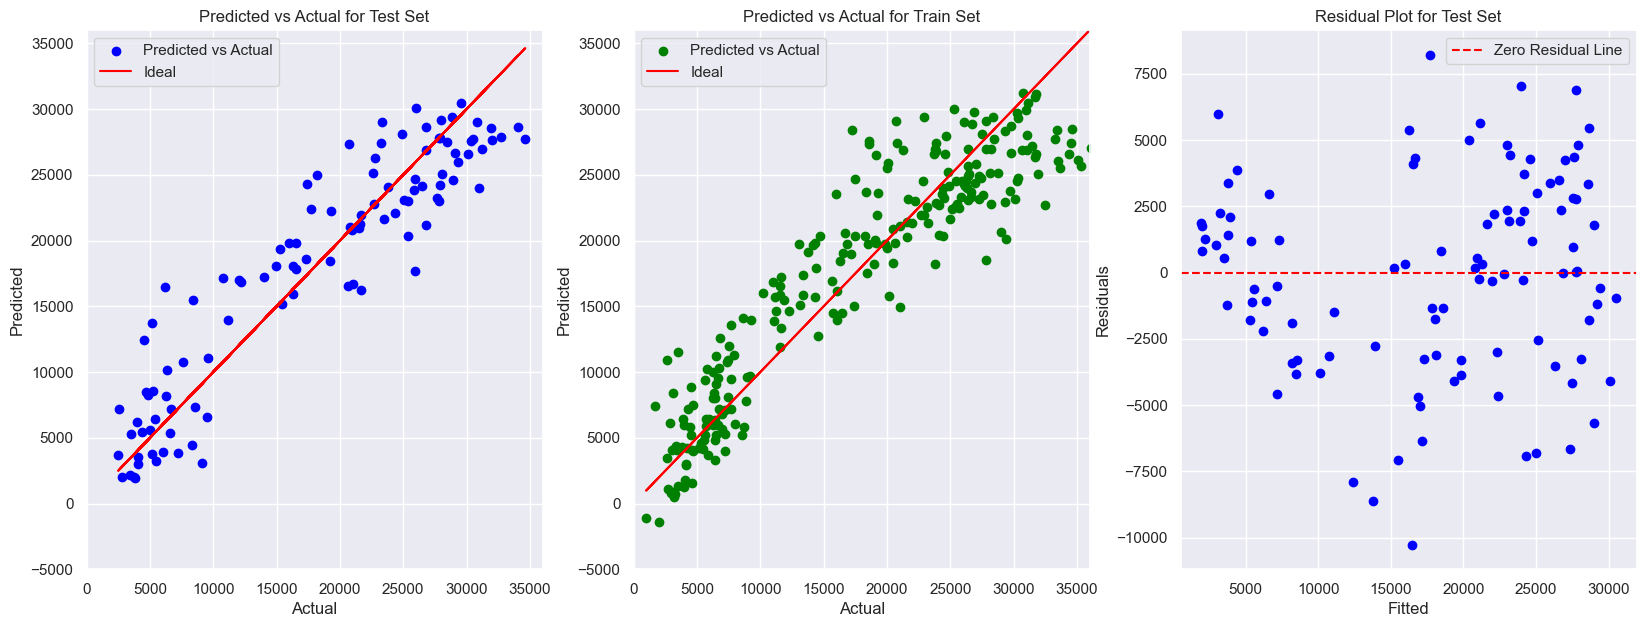

In [48]:
hub_model = HuberRegressor(alpha=1e-3, epsilon=1.35, max_iter=1000) # our best huber model
test_model(hub_model)

Test Accuracy: 90.82%
Train Accuracy: 95.48%
Accuracy Difference: -4.67%
Test Mean Squared Error: 8811861.03
Train Mean Squared Error: 4490834.40
Test Root Mean Squared Error: 2968.48
Alternatively, it's off by an average of 2968 bikes


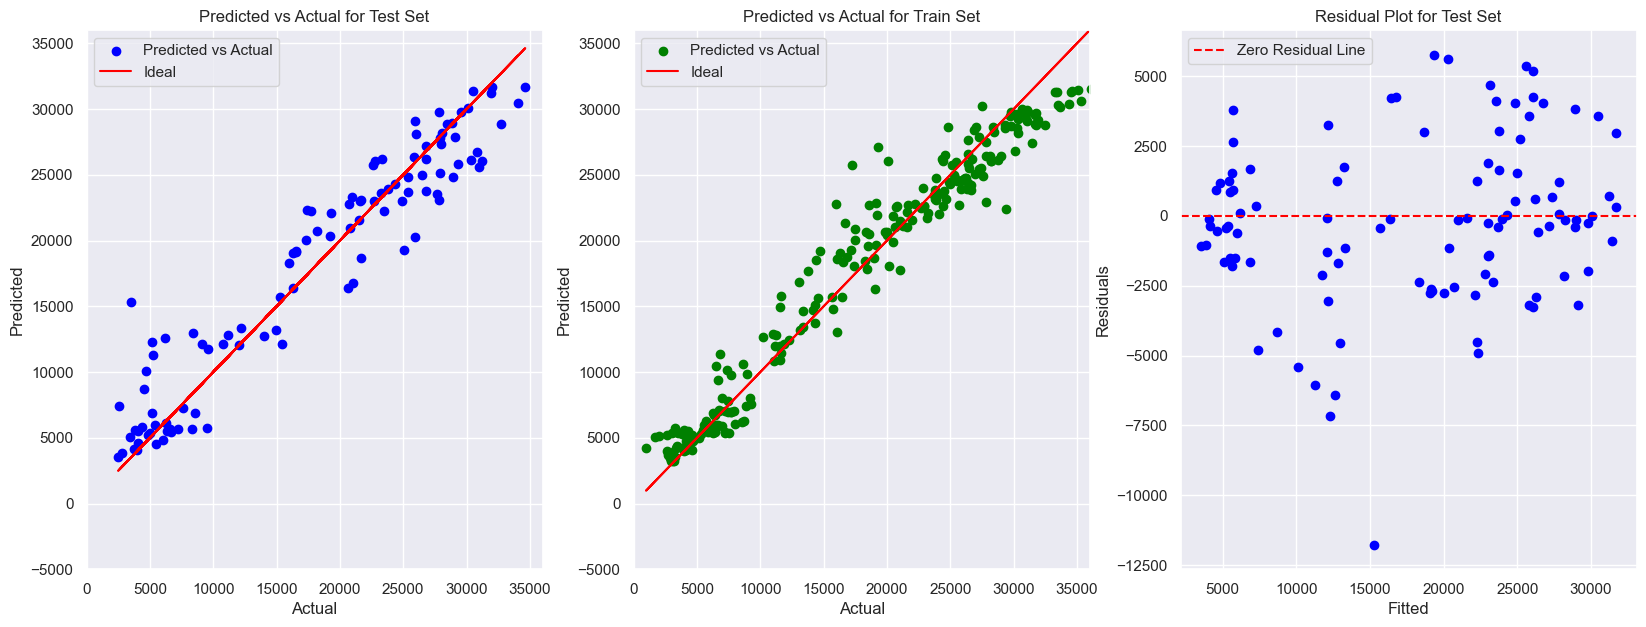

In [49]:
tree_model = ExtraTreesRegressor(max_depth=7,min_samples_leaf=3,min_samples_split=2,n_estimators=363, random_state=1) # our best elastic net model
test_model(tree_model)

# Our Holy Grail

Stacking it with Ridge seems to work the best so that's our final model

In [120]:
def finalTest(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    feature_names = X_train.columns
    coefs = model.coef_

    reg_equation = f"BikeCount = {model.intercept_:.2f}"
    for i, coef in enumerate(coefs):
        if coef > 0:
            reg_equation += f' + {coef:.2f}*{feature_names[i]}'
        else:
            reg_equation += f' - {abs(coef):.2f}*{feature_names[i]}'

    # Gathering other metrics
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    clear_output(True)
    print(f"Regression Equation:\n{reg_equation}")
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Train Root Mean Squared Error: {rmse_train:.2f}")

    # Visualizing
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(2, 2, figsize=(20,13))
    ax[0,0].set_title('Predicted vs Actual for Test Set')
    ax[0,0].scatter(y_test, test_pred, color='blue', label='Predicted vs Actual')
    ax[0,0].plot(y_test, y_test, color='red', label='Ideal')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Actual')
    ax[0,0].set_ylabel('Predicted')

    ax[0,1].set_title('Predicted vs Actual for Train Set')
    ax[0,1].scatter(y_train, train_pred, color='green', label='Predicted vs Actual')
    ax[0,1].plot(y_train, y_train, color='red', label='Ideal')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Actual')
    ax[0,1].set_ylabel('Predicted')

    test_residuals = y_test.reshape(-1,1) - test_pred.reshape(-1,1)
    ax[1,0].set_title('Residual Plot for Test Set')
    ax[1,0].scatter(test_pred, test_residuals, color='blue')
    ax[1,0].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,0].legend()
    ax[1,0].set_xlabel("Fitted")
    ax[1,0].set_ylabel("Residuals")

    train_residuals = y_train.reshape(-1,1) - train_pred.reshape(-1,1)
    ax[1,1].set_title('Residual Plot for Train Set')
    ax[1,1].scatter(train_pred, train_residuals, color='green')
    ax[1,1].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,1].legend()
    ax[1,1].set_xlabel("Fitted")
    ax[1,1].set_ylabel("Residuals")
    
    plt.show()

Regression Equation:
BikeCount = 18096.20 + 5458.82*Temperature(C) - 470.64*Humidity(%) - 495.29*Wind Speed(m/s) + 3241.51*Solar Radiation(MJ/m2) - 1614.26*Rainfall(mm) - 4134.24*Summer*Temp - 2835.71*Spring + 5988.38*Summer + 1710.50*Autumn - 4862.69*Winter - 2347.59*Weekend
Test Accuracy: 85.52%
Train Accuracy: 85.07%
Accuracy Difference: 0.45%
Test Mean Squared Error: 13901016.36
Train Mean Squared Error: 14847984.57
Test Root Mean Squared Error: 3728.41
Train Root Mean Squared Error: 3853.31


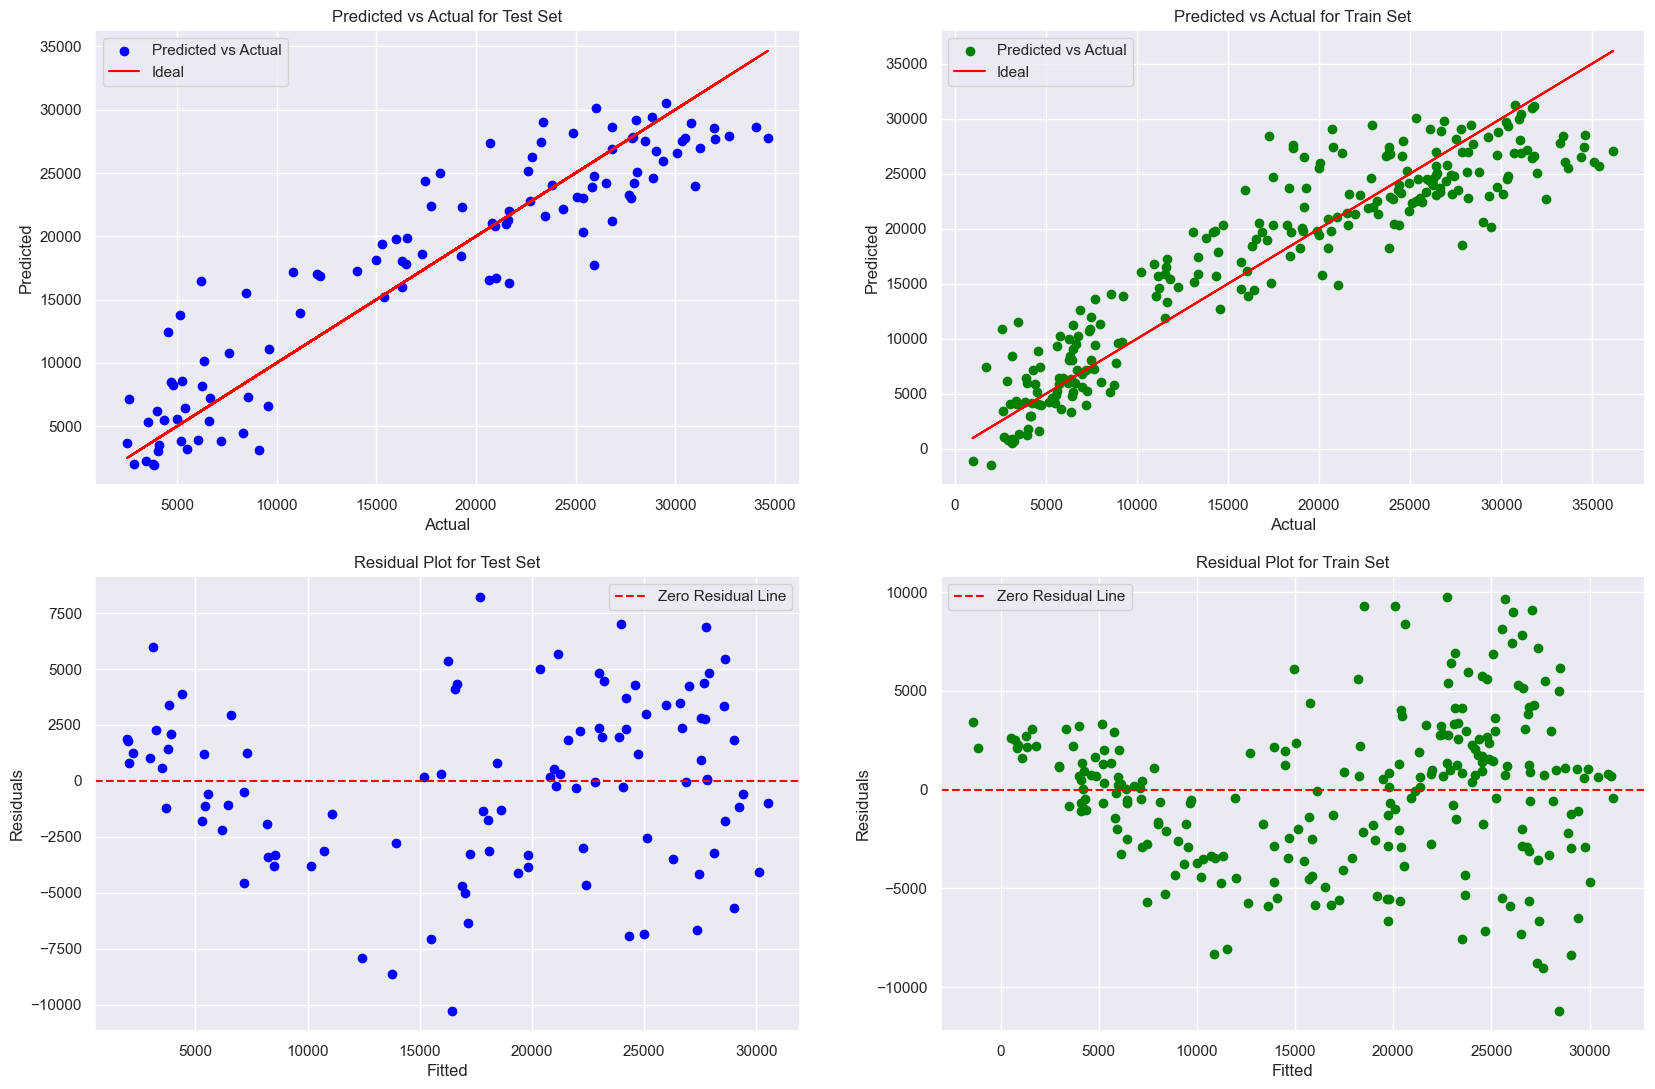

In [121]:
finalTest(hub_model)